In [1]:
import numpy as np

In [10]:
fisher = np.load('data/realfisher_10_False.npy')
summary = np.load('data/realsummary_10_False.npy')
lhd_summary = np.load('data/lhd_summaries_10_False.npy')
thetas = np.load('data/theta_lhd_10_False.npy')

In [3]:
fisher

array([[4446108.5, 1470053.6],
       [1470053.6, 1944223.9]], dtype=float32)

In [4]:
w, v  = np.linalg.eig(fisher)

In [8]:
np.dot(v, summary.T)

array([[-133.38474],
       [ 119.41726]], dtype=float32)

In [13]:
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


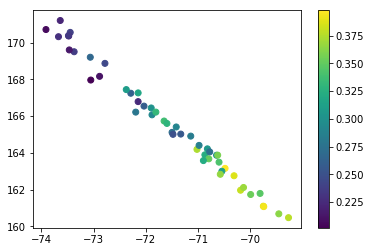

In [16]:
plt.scatter(lhd_summary[:,0], lhd_summary[:,1], c = thetas[:,0])
plt.colorbar()

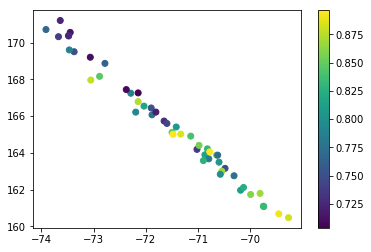

In [17]:
plt.scatter(lhd_summary[:,0], lhd_summary[:,1], c = thetas[:,1])
plt.colorbar()

In [23]:
new_lhd_summary = np.zeros_like(lhd_summary)

In [28]:
for i in range(len(lhd_summary)):
    new_lhd_summary[i,:] = np.dot(v.T, lhd_summary[i,:])

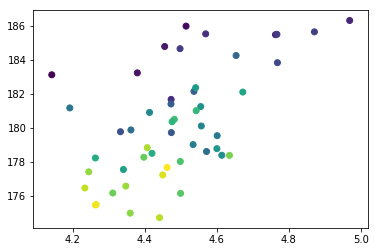

In [29]:
plt.scatter(new_lhd_summary[:,0], new_lhd_summary[:,1], c = thetas[:,0])

In [27]:
np.dot(v.T, v)

array([[ 1.000000e+00, -5.707971e-09],
       [-5.707971e-09,  1.000000e+00]], dtype=float32)

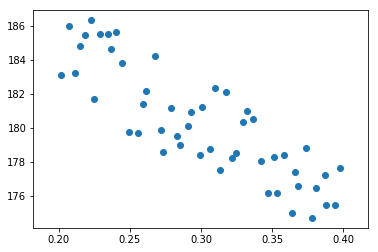

In [36]:
plt.scatter(thetas[:,0], new_lhd_summary[:,1])

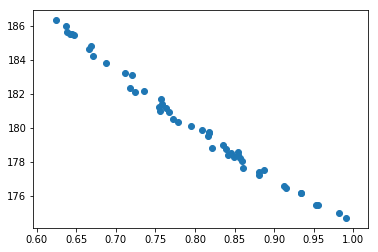

In [35]:
plt.scatter(thetas[:,1]*(thetas[:,0]/0.3)**.5, new_lhd_summary[:,1])

In [37]:
import george

In [38]:
from george import kernels

In [85]:
y = new_lhd_summary[:,1]
t = thetas.copy()
t[:,1] = t[:,1]*(t[:,0]/0.3)**.5

In [138]:
kernel = 100.*kernels.ExpSquaredKernel(20.0 , ndim = 2)

In [139]:
gp = george.GP(kernel, mean=np.mean(y), fit_mean=True)

In [140]:
gp.compute(t)

In [141]:
import scipy.optimize as op

# Define the objective function (negative log-likelihood in this case).
def nll(p):
    # Update the kernel parameters and compute the likelihood.
    gp.set_parameter_vector(p)
    ll = gp.lnlikelihood(y, quiet=True)

    # The scipy optimizer doesn't play well with infinities.
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    # Update the kernel parameters and compute the likelihood.
    gp.set_parameter_vector(p)
    return -gp.grad_lnlikelihood(y, quiet=True)

# You need to compute the GP once before starting the optimization.
gp.compute(t)

# Print the initial ln-likelihood.
print(gp.lnlikelihood(y))

# Run the optimization routine.
p0 = gp.get_parameter_vector()
print p0
results = op.minimize(nll, p0, jac=grad_nll)
print results.x
# Update the kernel and print the final log-likelihood.
gp.set_parameter_vector(results.x)
print(gp.lnlikelihood(y))


-10725231126.919409
[180.26257324   3.91202301   2.99573227]
[180.26257381   4.77420489   1.91396989]
-9761976140.781916


In [142]:
t0, t1 = np.linspace(0.2,0.4, 20), np.linspace(0.6,1.0, 20)
tnew = np.meshgrid(t0,t1)
# tnew is (400,2)
tnew = np.array(tnew).reshape(2,-1).T
tt0, tt1 = np.meshgrid(t0,t1)

In [143]:
mu, cov = gp.predict(y, tnew)

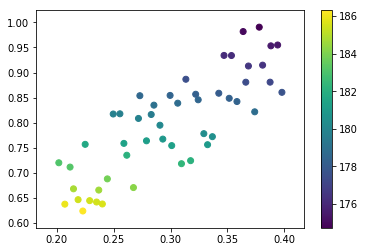

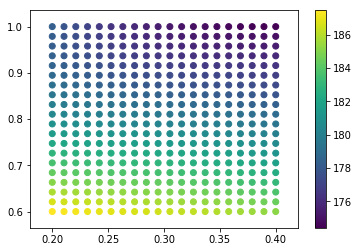

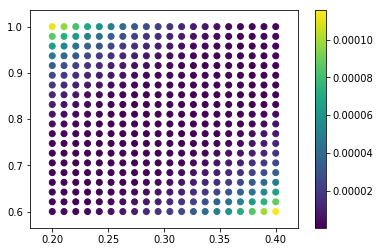

In [144]:
plt.scatter(t[:,0], t[:,1] , c = y)
plt.colorbar()
plt.show()
plt.close()

plt.scatter(tt0.flatten(), tt1.flatten(), c = mu)
plt.colorbar()
plt.show()
plt.close()

plt.scatter(tt0.flatten(), tt1.flatten(), c = np.diag(cov)**.5)
plt.colorbar()
plt.show()
plt.close()

In [145]:
mu_old, cov = gp.predict(y, t)

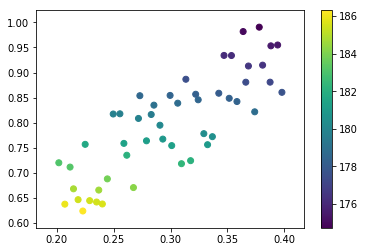

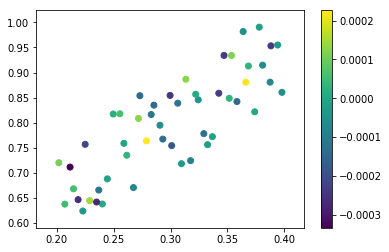

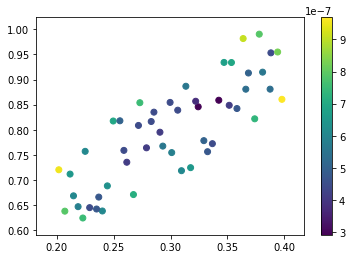

In [150]:
plt.scatter(t[:,0], t[:,1] , c = y)
plt.colorbar()
plt.show()
plt.close()

plt.scatter(t[:,0], t[:,1] , c = (y-mu_old)/y)
plt.colorbar()
plt.show()
plt.close()

plt.scatter(t[:,0], t[:,1] , c = np.diag(cov)**.5)
plt.colorbar()
plt.show()
plt.close()

In [151]:
tnew.shape

(400, 2)

In [152]:
tnew = np.array([0.3,0.8]).reshape(1,2)

In [155]:
mu, cov = gp.predict(y, tnew)
print mu

[179.91882381]


In [156]:
#http://www.gaussianprocess.org/gpml/chapters/RW2.pdf